
## Stocks_Sentiment_Analysis_Using_AI

In [ ]:

# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [6]:
# load the stock news data
stock_df = pd.read_csv("stock_sentiment.csv")
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [7]:
# dataframe information
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [8]:
# check for null values
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



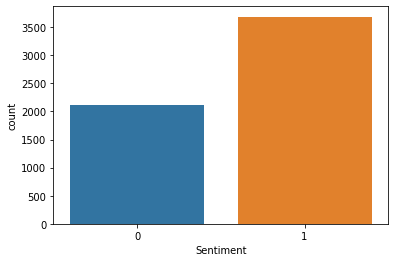

In [9]:
# check for number of unique sebtiments
sns.countplot(stock_df['Sentiment'])

### Preprocessing and data cleaning

In [12]:
# Function to remove punctuation marks
import string
string.punctuation
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    # Join the characters again to form the string
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [13]:
# Remove punctuations from our dataset 
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)

In [45]:
# Remove stopwords from our dataset 
# download stopwords
nltk.download("stopwords")
stopwords.words('english')
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['httpstco','goog','from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [46]:
# apply pre-processing to the text column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [17]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [47]:
# join the words into a string
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

In [40]:
stock_df['Text Without Punc & Stopwords Joined'][0]

'kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts'

### Plot Wordcloud

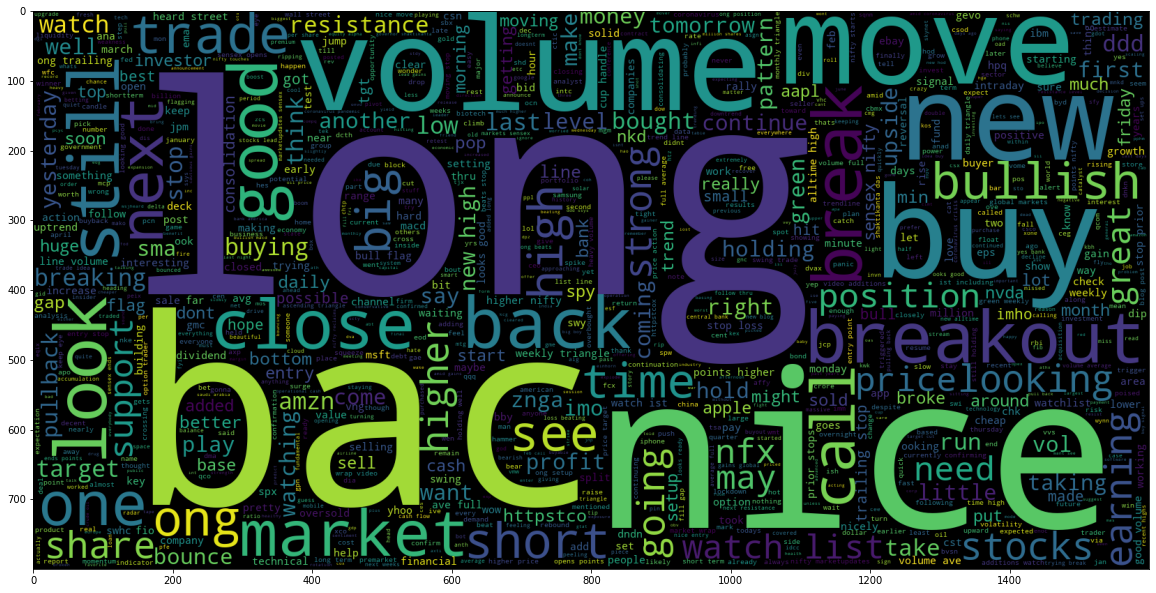

In [41]:
# plot the word cloud for text with positive sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc);

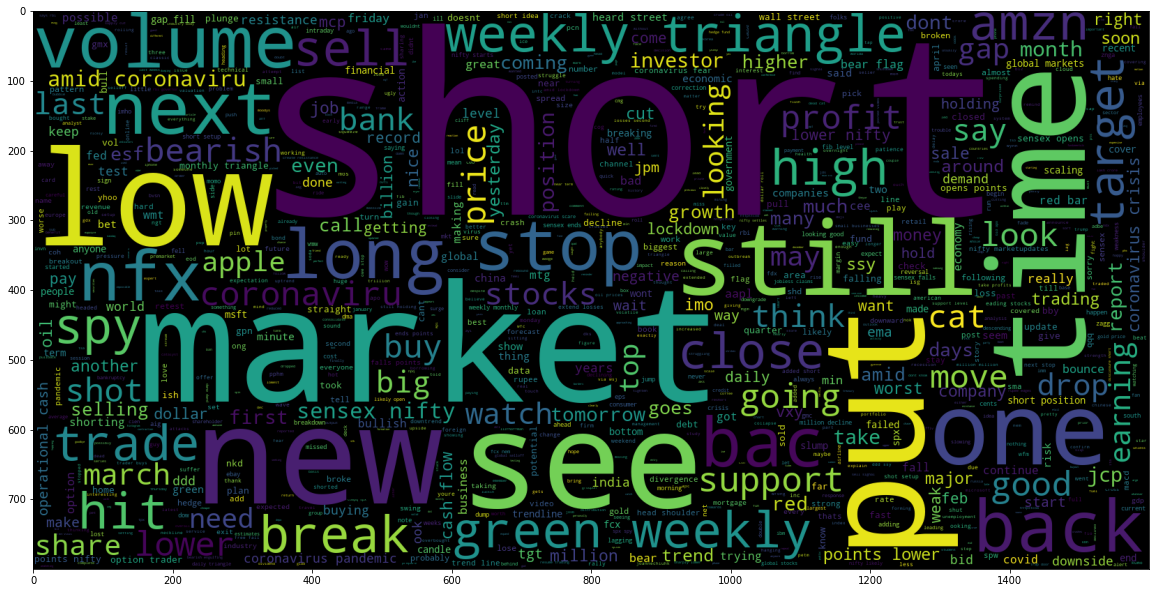

In [48]:
# plot the word cloud for text with positive sentiment
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc);

### Visualize cleaned dataset

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [51]:
# word_tokenize is used to break up a string into words
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [52]:
# Obtain the maximum length of data in the document
# This will be later used when word embeddings are generated
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 20


In [53]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]
tweets_length

[14,
 6,
 7,
 1,
 0,
 1,
 8,
 13,
 7,
 4,
 10,
 18,
 8,
 8,
 11,
 5,
 12,
 10,
 12,
 4,
 6,
 5,
 2,
 5,
 3,
 10,
 3,
 3,
 9,
 6,
 8,
 10,
 8,
 2,
 10,
 11,
 4,
 8,
 11,
 10,
 10,
 7,
 9,
 8,
 4,
 10,
 8,
 7,
 7,
 9,
 10,
 10,
 8,
 2,
 14,
 11,
 9,
 8,
 1,
 14,
 6,
 11,
 5,
 13,
 6,
 6,
 6,
 5,
 6,
 10,
 9,
 4,
 10,
 13,
 16,
 6,
 9,
 6,
 2,
 11,
 5,
 4,
 8,
 11,
 16,
 4,
 9,
 5,
 6,
 2,
 1,
 5,
 9,
 4,
 7,
 6,
 7,
 10,
 1,
 3,
 9,
 4,
 16,
 8,
 10,
 11,
 18,
 6,
 7,
 13,
 12,
 9,
 3,
 3,
 10,
 10,
 8,
 6,
 8,
 5,
 5,
 8,
 9,
 15,
 3,
 5,
 9,
 18,
 13,
 10,
 3,
 1,
 1,
 2,
 7,
 12,
 12,
 8,
 8,
 10,
 9,
 10,
 15,
 8,
 9,
 9,
 11,
 10,
 6,
 10,
 13,
 4,
 11,
 8,
 15,
 13,
 8,
 12,
 4,
 5,
 3,
 7,
 2,
 4,
 10,
 5,
 6,
 10,
 6,
 14,
 8,
 6,
 4,
 10,
 9,
 10,
 8,
 2,
 10,
 9,
 10,
 12,
 7,
 10,
 7,
 3,
 6,
 5,
 9,
 9,
 4,
 6,
 5,
 4,
 4,
 8,
 9,
 8,
 8,
 13,
 9,
 7,
 10,
 12,
 7,
 6,
 5,
 2,
 10,
 11,
 6,
 9,
 10,
 13,
 10,
 7,
 12,
 7,
 11,
 10,
 4,
 4,
 3,
 10,
 2,
 9,
 10,
 15,
 12,
 10,

In [60]:
# Plot the distribution for the number of words in a text
fig = px.histogram(x = tweets_length, nbins = 45)
fig.show()


### Prepare the data by tokenizing and padding

In [62]:
# Obtain the total words present in the dataset
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)
list_of_words        

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts',
 'movie',
 'return',
 'feageed',
 'indicator',
 'trades',
 'awesome',
 'afraid',
 'short',
 'amzn',
 'looking',
 'like',
 'nearmonopoly',
 'ebooks',
 'mnta',
 'pgnx',
 'current',
 'downtrend',
 'break',
 'otherwise',
 'shortterm',
 'correction',
 'medterm',
 'downtrend',
 'mondays',
 'relative',
 'weakness',
 'nyx',
 'win',
 'tie',
 'tap',
 'ice',
 'int',
 'bmc',
 'aon',
 'chk',
 'biib',
 'ower',
 'trend',
 'line',
 'channel',
 'test',
 'volume',
 'support',
 'watch',
 'tomorrow',
 'ong',
 'entry',
 'assuming',
 'fcx',
 'opens',
 'tomorrow',
 'trigger',
 'buy',
 'still',
 'much',
 'like',
 'setup',
 'really',
 'worries',
 'everyone',
 'expects',
 'market',
 'rally',
 'nowusually',
 'exact',
 'opposite',
 'happens',
 'every',
 'time',
 'shall',
 'see',
 'soon',
 'bac',
 'spx',
 'jpm',
 'gamcos',
 'arry',
 'haverty',
 'apple',
 'extremely',
 'cheap',
 'gre

In [63]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9266

In [89]:
# Split the data into test and train datasets
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

# Use 15 percent of the data for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [90]:
X_train.shape

(5211,)

In [91]:
X_test.shape

(580,)

In [92]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)


In [93]:
train_sequences[0:5]

[[1291, 21, 253, 10, 272, 136],
 [1880, 120, 128, 518, 1, 1292, 367, 1119, 481, 163, 247, 1293],
 [1120, 415, 3617, 1294, 640, 3618, 2471, 3619, 3620, 3621, 3622, 3623],
 [392, 773, 218, 3624, 11, 2472, 89],
 [1881, 1882, 12, 26, 77, 966, 57, 94]]

In [94]:
test_sequences[0:5]

[[246, 5347, 16, 1183, 32, 3069, 19, 59, 175, 27],
 [1615, 32, 217, 1716, 114, 993, 74, 1, 217, 265, 631, 34],
 [3182, 31, 311, 1409],
 [],
 [408, 120, 104, 252]]

In [95]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 2106    [twi, added, small, cap, short, int, cheap, va...
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [1880, 120, 128, 518, 1, 1292, 367, 1119, 481, 163, 247, 1293]


In [96]:
# Add padding to training and testing to make all vectors fo the same size
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [97]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [1291   21  253   10  272  136    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [1880  120  128  518    1 1292  367 1119  481  163  247 1293    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [1120  415 3617 1294  640 3618 2471 3619 3620 3621 3622 3623    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [98]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [99]:
y_train_cat[0:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Building a custom based deep neural network to perform sentiment analysis

In [100]:
# Sequential Model
model = Sequential()

# Embedding layer: This layer helps the model learn the low dimensional
# continous representation of discrete input variables, i.e. huge bumber of unique
# values could be represented in very few variables. Similar to PCA.
model.add(Embedding(total_words, output_dim = 512))

# Bi-Directional RNN and LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 512)         4744192   
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 5,564,802
Trainable params: 5,564,802
Non-trainable params: 0
_________________________________________________________________


In [105]:
# train the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2)

Epoch 1/2
131/131 [==============================] - 37s 286ms/step - loss: 0.3760 - acc: 0.8565 - val_loss: 0.5538 - val_acc: 0.7344
Epoch 2/2
131/131 [==============================] - 37s 283ms/step - loss: 0.2309 - acc: 0.9194 - val_loss: 0.5745 - val_acc: 0.7373


### Assess the trained model performance

In [106]:
# Make prediction using the model
pred = model.predict(padded_test)

# put prediction values in a list
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

# list containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [107]:
# Acuracy score on text data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.6275862068965518

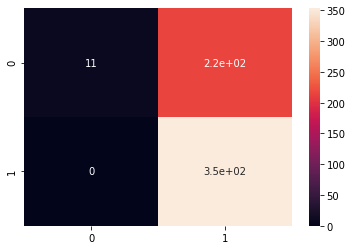

In [108]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)